# Figures for paper

In [1]:
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import torch
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import ScalarFormatter
import importlib
importlib.import_module('mpl_toolkits').__path__
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr, gaussian_kde
from scipy.ndimage.filters import gaussian_filter1d
from seaborn import kdeplot
from scipy.signal import savgol_filter
from matplotlib.legend_handler import HandlerTuple
from legendkit import legend

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "arial"

mpl.rc('text', usetex = True)
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
params= {'text.latex.preamble' : r'\usepackage{amsmath}'}
plt.rcParams.update(params)

/home/sanderdh/miniconda3/envs/dfc_environment/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Calcium

In [2]:
def calcium_plasticity(calcium, alpha_1=0.6, beta_1=25, alpha_2=0.35, beta_2=60):
    return 1 / (1 + np.exp(-beta_1*(calcium-alpha_1))) - 0.25 / (1 + np.exp(-beta_2*(calcium-alpha_2)))

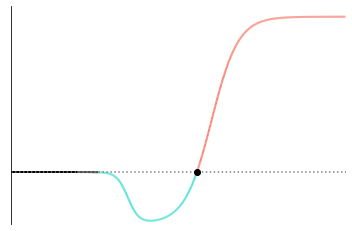

In [ ]:
fig, ax = plt.subplots()

x = np.linspace(0,1,1000)
y = calcium_plasticity(x)

cmap = ListedColormap(['turquoise', 'k', 'salmon'])
norm = BoundaryNorm([np.min(y), -0.001, 0.001, np.max(y)], cmap.N)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2)
lc.set_array(y)

ax.add_collection(lc)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y)*1.1, np.max(y)*1.1)

plt.hlines(0,0,1,linestyles='dotted',colors='grey')
plt.plot(0.556,0,'ko') 

plt.xlim((0,1))
plt.ylim((-0.25,0.80))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('figs/calcium.png', dpi=360, bbox_inches="tight")

# Single Neuron Model

In [36]:
time = 1000 # ms/10 (ticks)
start = 15 # ms

resting = -78 # mV
threshold = -63 # mV
peak = 40 # mV
depression = -75 # mV
post_spike = -70 # mV

epsp_fall = 10
epsp_rise = 150
fb_curvature = 7
bap_rise = 400
bap_fall = 50
bap_curvature = 20

calcium_delay = 5 # ms
fb_delay = 3 # ms
bap_delay = 10 # ticks

spike_duration = 50 # ticks
rise_duration = 10 # ticks
repolarization = 20 # ticks
refractory = 20 # ticks

def epsp(a, up, down, time):
    a /= 100
    x = np.linspace(0,(time-1)/1000, time)
    return np.exp(-down * (x - a)) / (1 + np.exp(-up * (x - a)))

def calcium_curve(a, time):
    a /= 100
    x = np.linspace(0,(time-1)/1000, time)
    return 1.2 / (1 + np.exp(-150*(x-a))) - 0.2 / (1 + np.exp(-20*(x-(a+0.1)))) - 1 / (1 + np.exp(-10*(x-(a+2.5))))

def insert_spike(V, t, plateau):
    # to peak
    for i in range(0,rise_duration):
        V[t+i] = V[t+i-1] + 1/5 * ( - V[t+i-1] + peak )
    # repolarization
    for i in range(rise_duration,rise_duration+repolarization):
        V[t+i] = V[t+i-1] + 1/5 * ( - V[t+i-1] + np.max([depression, plateau[t]]))
    # refractory 
    for i in range(rise_duration+repolarization,spike_duration):
        V[t+i] = V[t+i-1] + 1/5 * ( - V[t+i-1] + np.max([post_spike, plateau[t]]))

def generate_spikes(inputs, plateau):
    spike_times = []
    V_soma = np.zeros(time)
    V_soma[0] = resting

    t = 1
    while t < time:
        V_soma[t] = V_soma[t-1] + 1/5 * ( - V_soma[t-1] + inputs[t])
        if V_soma[t] > threshold: # spike
            spike_times.append(t+1)
            insert_spike(V_soma, t+1, plateau)
            t += spike_duration
        t += 1

    return spike_times, V_soma

vgcc_influx = lambda x: 1/(1+np.exp(-0.25*(x+49)))
# attentuate_calcium = lambda x: 1/(1+np.exp(10*(x-0.7)))

In [52]:
# somatic
pre_epsp = epsp(start, epsp_rise, epsp_fall, time) * 20 + resting
calcium_soma = calcium_curve(start+calcium_delay+2.9, time) * 12 + resting
inputs_fb = pre_epsp + calcium_soma - resting
inputs_nofb = pre_epsp

spike_times, V_soma = generate_spikes(inputs_fb, calcium_soma)
_, V_soma_nofb = generate_spikes(inputs_nofb, np.ones(time) - 1000)

# apical
apical_epsp = epsp(start+fb_delay, epsp_rise, epsp_fall, time) * 15 + resting
bap = np.sum(np.fromiter((epsp((spike_time+bap_delay)/10, bap_rise, bap_fall, time) * 20), dtype=np.float64) for spike_time in spike_times) + resting
calcium_apical = calcium_curve(spike_times[0]/10+calcium_delay, time) * 12 + resting
V_apical = apical_epsp + bap + calcium_apical - resting * 2

bap_nofb = epsp((spike_times[0]+bap_delay)/10, bap_rise, bap_fall, time) * 20 + resting
epsp_nofb = epsp(start, epsp_rise, epsp_fall, time) * 20 + resting
inputs_nofb = bap_nofb + epsp_nofb - resting

# synaptic / calcium
pre_epsp_synapse = epsp(start, epsp_rise, epsp_fall, time) * 10 + resting
bap_synapse = np.sum(np.fromiter((epsp((spike_time+bap_delay)/10, bap_rise, bap_fall, time) * 20), dtype=np.float64) for spike_time in spike_times) + resting
calcium_synapse = (calcium_curve(start+calcium_delay+3.9, time) * 12) * 0.5 + resting
bap_nofb_synapse = epsp((spike_times[0]+bap_delay)/10, bap_rise, bap_fall, time) * 22 + resting
V_spine = pre_epsp_synapse + gaussian_filter1d(calcium_synapse + bap_synapse, 1) - resting * 2
V_spine_nofb = (pre_epsp_synapse + gaussian_filter1d(bap_nofb_synapse, 1) - resting)

tau_c_decay = 500
tau_c_influx = 10
calcium_fb = np.zeros(time)
calcium_nofb = np.zeros(time)
calcium_max = 0.35

for t in range(time-1):
    calcium_fb[t+1] = calcium_fb[t] + 1/tau_c_decay *  - calcium_fb[t] + 1/tau_c_influx * (calcium_max-calcium_fb[t]/calcium_max) * vgcc_influx(V_spine[t]) 
for t in range(time-1):
    calcium_nofb[t+1] = calcium_nofb[t] + 1/tau_c_decay *  - calcium_nofb[t] + 1/tau_c_influx * (calcium_max-calcium_fb[t]/calcium_max) * vgcc_influx(V_spine_nofb[t])


<ipython-input-52-35b30167d4a3>:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bap = np.sum(np.fromiter((epsp((spike_time+bap_delay)/10, bap_rise, bap_fall, time) * 20), dtype=np.float64) for spike_time in spike_times) + resting
<ipython-input-52-35b30167d4a3>:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bap_synapse = np.sum(np.fromiter((epsp((spike_time+bap_delay)/10, bap_rise, bap_fall, time) * 20), dtype=np.float64) for spike_time in spike_times) + resting


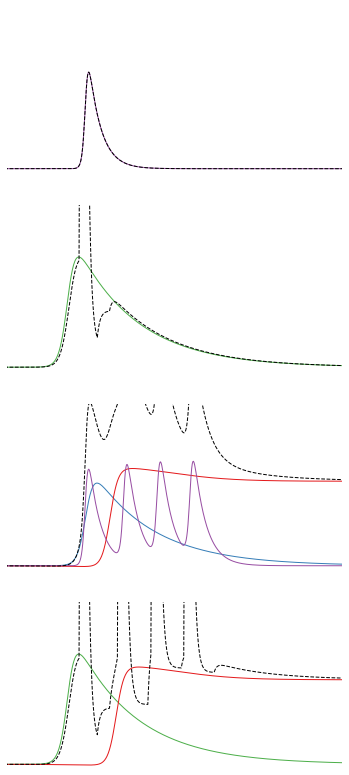

In [53]:
fig, (ap_ltd, bas_ltd, ap_ltp, bas_ltp) = plt.subplots(4, 1, figsize=(6,14))

xlim = (50,600)
ylim = (-78.5,-55)
linewidth = 1

ap_ltd.plot(bap_nofb, c='#984ea3', linewidth = linewidth)
ap_ltd.plot(bap_nofb, c='k', linestyle='--', linewidth = linewidth)
ap_ltd.set_xlim(xlim)
ap_ltd.set_ylim(ylim)
ap_ltd.spines[['right', 'left', 'bottom', 'top']].set_visible(False)
ap_ltd.set_xticks([])
ap_ltd.set_xticks([], minor=True)
ap_ltd.set_yticks([])
ap_ltd.set_yticks([], minor=True)

bas_ltd.plot(epsp_nofb, c='#4daf4a', linewidth = linewidth)
bas_ltd.plot(V_soma_nofb, c='k', linestyle='--', linewidth = linewidth)
bas_ltd.set_xlim(xlim)
bas_ltd.set_ylim(ylim)
bas_ltd.spines[['right', 'left', 'bottom', 'top']].set_visible(False)
bas_ltd.set_xticks([])
bas_ltd.set_xticks([], minor=True)
bas_ltd.set_yticks([])
bas_ltd.set_yticks([], minor=True)

ap_ltp.plot(apical_epsp, c='#377eb8', linewidth = linewidth)
ap_ltp.plot(calcium_apical, c='#e41a1c', linewidth = linewidth)
ap_ltp.plot(bap, c='#984ea3', linewidth = linewidth)
ap_ltp.plot(apical_epsp+calcium_apical+bap-resting*2, c='k', linestyle='--', linewidth = linewidth)
ap_ltp.set_xlim(xlim)
ap_ltp.set_ylim(ylim)
ap_ltp.spines[['right', 'left', 'bottom', 'top']].set_visible(False)
ap_ltp.set_xticks([])
ap_ltp.set_xticks([], minor=True)
ap_ltp.set_yticks([])
ap_ltp.set_yticks([], minor=True)

bas_ltp.plot(pre_epsp, c='#4daf4a', linewidth = linewidth)
bas_ltp.plot(calcium_soma, c='#e41a1c', linewidth = linewidth)
bas_ltp.plot(V_soma, c='k', linestyle='--', linewidth = linewidth)
bas_ltp.set_xlim(xlim)
bas_ltp.set_ylim(ylim)
bas_ltp.spines[['right', 'left', 'bottom', 'top']].set_visible(False)
bas_ltp.set_xticks([])
bas_ltp.set_xticks([], minor=True)
bas_ltp.set_yticks([])
bas_ltp.set_yticks([], minor=True)

plt.savefig(f'figs/fig2_lines.svg', format='svg', bbox_inches="tight")
plt.savefig(f'figs/fig2_lines.png', dpi=360, bbox_inches="tight")

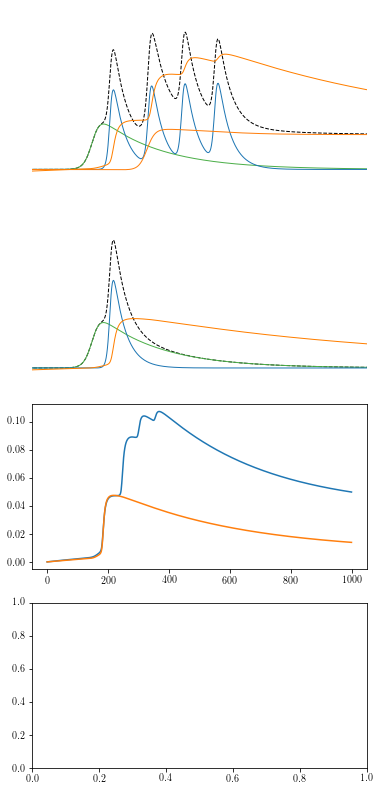

In [59]:
fig, (cad, cap, test, _) = plt.subplots(4, 1, figsize=(6,14))

limy_v = (-78.5, -50)
limy_c = (0, 0.15)
limx = (50,600)
linewidth = 1

cad.plot(V_spine, c='k', linestyle='--', linewidth = linewidth)
cad.plot(pre_epsp_synapse, c='#4daf4a', linewidth = linewidth)
cad.plot(bap_synapse, linewidth = linewidth)
cad.plot(calcium_synapse, linewidth = linewidth)
cad.set_ylim(limy_v)
cad.set_xlim(limx)
cad.axis('off')
cad2 = cad.twinx()
cad2.plot(calcium_fb, c='#ff7f00', linewidth = linewidth)
cad2.set_ylim(limy_c)
cad2.set_xlim(limx)
cad2.axis('off')

cap.plot(V_spine_nofb, c='k', linestyle='--', linewidth = linewidth)
cap.plot(pre_epsp_synapse, c='#4daf4a', linewidth = linewidth)
cap.plot(bap_nofb_synapse, linewidth = linewidth)
cap.set_ylim(limy_v)
cap.set_xlim(limx)
cap.axis('off')
cap2 = cap.twinx()
cap2.plot(calcium_nofb*0.8, c='#ff7f00', linewidth = linewidth)
cap2.set_ylim(limy_c)
cap2.set_xlim(limx)
cap2.axis('off')

test.plot(calcium_fb)
test.plot(calcium_nofb*0.8)

plt.savefig(f'figs/fig2_calcium.svg', format='svg', bbox_inches="tight")
plt.savefig(f'figs/fig2_calcium.png', dpi=360, bbox_inches="tight")

### Two neuron learning

In [19]:
w = torch.tensor([0.1, 0.9])
a = (torch.tensor([1, 0]), torch.tensor([0.9]))
b = (torch.tensor([0, 1]), torch.tensor([0.1]))
num_stim = 100
scale = 1.0
step = 0.3
threshold = 0.1
delta_spike = 0.1
delta_burst = 0.9

controller = lambda targ, pred: torch.nn.Sigmoid()(scale * (targ - pred))

i = 0
examples = 1500
ws_spike = []
fbs_spike = []
mses_spike = []
updates_spike = []
burst_prop = []

while i < examples:
    stim, targ = a if i % 2 else b
    
    pre = stim * w
    pred = torch.sum( pre )
    controller_signal = targ - pred
    mse = torch.nn.MSELoss()(pred, targ)
    probability_burst = torch.nn.Sigmoid()(controller_signal) * (2*delta_spike/(delta_spike+delta_burst))
    
    teaching_signal = torch.sum((-1*(torch.rand(num_stim) > probability_burst)*delta_spike+1*(torch.rand(num_stim) <= probability_burst)*delta_burst)) / num_stim

    w += step * pre * teaching_signal

    burst_prop.append(probability_burst.item())
    ws_spike.append(w.clone().numpy())
    fbs_spike.append(controller_signal.item())
    mses_spike.append(mse)
    updates_spike.append(w[0] + pre[0]*teaching_signal)
    
    i += 1

mses_spike = np.repeat([sum(mses_spike[i:i+2]) for i in range(0, len(mses_spike), 2)], 2)
fbs_spike = [abs(x) for x in fbs_spike]
fbs_spike = np.repeat([sum(fbs_spike[i:i+2]) for i in range(0, len(fbs_spike), 2)], 2)
burst_prop_a = np.repeat(burst_prop[::2], 2)
burst_prop_b = np.repeat(burst_prop[1::2], 2)

/home/sanderdh/miniconda3/envs/dfc_environment/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


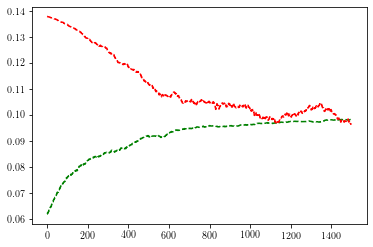

In [25]:
plt.plot(burst_prop_a, '--', c='green')
plt.plot(burst_prop_b, '--', c='red')
plt.savefig(f'figs/burst_probability.svg', format='svg', bbox_inches="tight")

In [22]:
w = torch.tensor([0.1, 0.9])
a = (torch.tensor([1, 0]), torch.tensor([0.711]), torch.tensor([0.9])) # Sigmoid targets
b = (torch.tensor([0, 1]), torch.tensor([0.525]), torch.tensor([0.1]))
scale = 1.0
step = 0.3
threshold = 0.1

i = 0
examples = 1500
ws_rate = []
fbs_rate = []
mses_rate = []
ts_rate = []
updates_rate = []

while i < examples:
    stim, targ, msetarg = a if i % 2 else b
    
    v_fb = 1
    v_fb_new = 0
    iter = 0
    max_iter = 30
    eps = 1e-7
    gamma = 0.2
    pre = stim * w
    v_ff = torch.sum ( pre )

    while (np.abs(v_fb - v_fb_new) > eps and iter != max_iter):
        v_fb = v_fb_new

        v = v_ff + v_fb
        pred = torch.nn.Sigmoid()(v) * (1 + gamma * (torch.nn.Sigmoid()(torch.tensor([v_fb])) - 0.5))

        v_fb_new = targ - pred

        iter += 1

    v = v_ff + v_fb_new
    pred = torch.sum( pre )
    mse = torch.nn.MSELoss()(pred, msetarg)
    teaching_signal = torch.nn.Sigmoid()(v) - torch.nn.Sigmoid()(v_ff)

    w += step * pre * teaching_signal

    ts_rate.append(teaching_signal)
    ws_rate.append(w.clone().numpy())
    fbs_rate.append(v_fb.item())
    mses_rate.append(mse)
    updates_rate.append(pre[stim[1]]*teaching_signal)
    
    i += 1

mses_rate = np.repeat([sum(mses_rate[i:i+2]) for i in range(0, len(mses_rate), 2)], 2)
fbs_rate = [abs(x) for x in fbs_rate]
fbs_rate = np.repeat([sum(fbs_rate[i:i+2]) for i in range(0, len(fbs_rate), 2)], 2)

/home/sanderdh/miniconda3/envs/dfc_environment/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [23]:
w = torch.tensor([0.1, 0.9])
a = (torch.tensor([1, 0]), torch.tensor([1]))
b = (torch.tensor([0, 1]), torch.tensor([0]))
scale = 1.0
step = 0.05
threshold = 0.1

i = 0
examples = 1500
updates = []
ws = []

delta_spike = 0.1
delta_burst = 0.9


while i < examples:
    stim, targ = a if i % 2 else b
    
    v_fb = 1
    v_fb_new = 0
    iter = 0
    max_iter = 30
    eps = 1e-7
    gamma = 0.2
    pre = stim * w
    v_ff = torch.sum ( pre )

    while (np.abs(v_fb - v_fb_new) > eps and iter != max_iter):
        v_fb = v_fb_new

        v = v_ff + v_fb
        pred_rate = torch.nn.Sigmoid()(v) * (1 + gamma * (torch.nn.Sigmoid()(torch.tensor([v_fb])) - 0.5))

        v_fb_new = torch.nn.Sigmoid()(targ) - pred_rate

        iter += 1

    v = v_ff + v_fb_new
    mse = torch.nn.MSELoss()(pred_rate, targ)
    teaching_signal_rate = torch.nn.Sigmoid()(v) - torch.nn.Sigmoid()(v_ff)

    pred_spike = torch.sum( pre )
    controller_signal = targ - pred_spike
    mse = torch.nn.MSELoss()(pred_spike, targ)
    probability_burst = torch.nn.Sigmoid()(controller_signal) * (2*delta_spike/(delta_spike+delta_burst))
    
    teaching_signal_spike = torch.sum((-1*(torch.rand(num_stim) > probability_burst)*delta_spike+1*(torch.rand(num_stim) <= probability_burst)*delta_burst)) / num_stim

    w += step * pre * teaching_signal_spike

    ws.append(w.clone().numpy())
    updates.append([pre[stim[1]]*teaching_signal_rate, pre[stim[1]]*teaching_signal_spike])
    
    i += 1

updates = np.array([np.array([a.item(), b.item()]) for a, b in updates])
dA = updates[1::2]
dB = updates[::2]
# dA = dA[::-1]
# dB = dB[::-1]

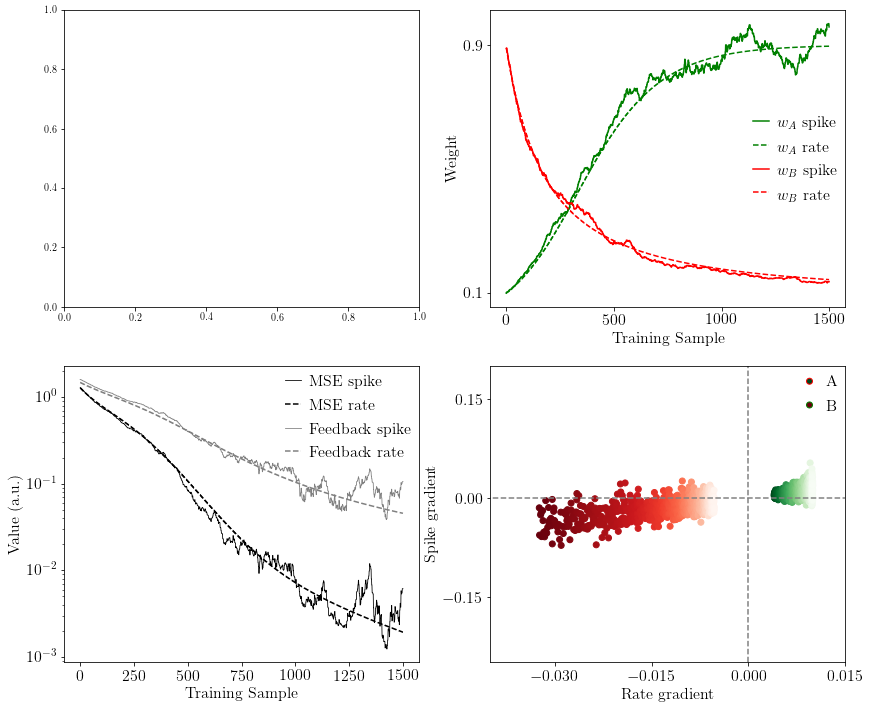

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,12))

fontsize = 16

spike_A, = ax2.plot([ws_spike[x][0] for x in range(len(ws_spike))][:1500], c='green', label='$w_A$ spike')
rate_A,  = ax2.plot([ws_rate[x][0] for x in range(len(ws_rate))][:1500], '--', c='green', label='$w_A$ rate')
spike_B, = ax2.plot([ws_spike[x][1] for x in range(len(ws_spike))][:1500], c='red', label='$w_B$ spike')
rate_B,  = ax2.plot([ws_rate[x][1] for x in range(len(ws_rate))][:1500], '--', c='red', label='$w_B$ rate')

ax2.set_xlabel("Training Sample", fontsize=fontsize)
ax2.set_ylabel("Weight", fontsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.legend(fontsize=fontsize)
ax2.yaxis.set_ticks([0.1,0.9])
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))

grad_c = [i/len(dA) for i in range(len(dA))]
# grad_c = grad_c[::-1]
ax4.scatter(dA[:,0], dA[:,1], c=grad_c, cmap='Greens_r', label="A")
ax4.scatter(dB[:,0], dB[:,1], c=grad_c , cmap='Reds_r', label="B")
ax4.axhline(0,-1,1, c='grey', linestyle='--')
ax4.axvline(0,-1,1, c='grey', linestyle='--')
ax4.set_xlabel("Rate gradient", fontsize=fontsize)
ax4.set_ylabel("Spike gradient", fontsize=fontsize)
ax4.set_xlim((-0.04,0.015))
ax4.set_ylim((-0.25,0.20))
ax4.tick_params(axis='both', labelsize=fontsize)
ax4.xaxis.set_major_locator(plt.MaxNLocator(4))
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.pcolor()
ax4.legend(fontsize=fontsize)
leg = ax4.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green')


mse_sp, = ax3.plot(mses_spike, c='k', linewidth=0.8, label="MSE spike")
mse_r, = ax3.plot(mses_rate, '--', c='k', label="MSE rate")
fbs_sp, = ax3.plot(fbs_spike, c='grey', linewidth=0.8, label="Feedback spike")
fbs_r, = ax3.plot(fbs_rate*5, '--', c='grey', label="Feedback rate")
ax3.set_yscale('log')
ax3.set_ylabel("Value (a.u.)", fontsize=fontsize)
ax3.set_xlabel("Training Sample", fontsize=fontsize)
ax3.tick_params(axis='both', labelsize=fontsize)
ax3.legend(loc="upper center", fontsize=fontsize)
ax3.legend(fontsize=fontsize)


plt.savefig(f'figs/two_neuron_example.png', dpi=360, bbox_inches="tight")
plt.savefig(f'figs/two_neuron_example.eps', format='eps', bbox_inches="tight")
plt.savefig(f'figs/two_neuron_example.svg', format='svg', bbox_inches="tight")

# Responses of variables

### Qualitative responses

In [3]:
def homogeneous_poisson(rate, tmax, bin_size):
    np.random.seed(0)
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

def add_bursts(xs, tmin, tmax):
    for t in np.linspace(tmax, tmin, tmax-tmin+1):
        if xs[int(t)] == 1:
            for i in range(1,4):
                xs[int(t)+8*i] = 1

def divide_spikes(spikes, epsp_indices):
    spike_indices = [i for i in range(len(spikes)) if spikes[i] == 1]
    return [spike_indices[index-1] for index in epsp_indices]

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcium_curve(a, time):
    a /= 100
    x = np.linspace(0,(time-1)/100, time)
    return 1.2 / (1 + np.exp(-150*(x-a))) - 0.2 / (1 + np.exp(-20*(x-(a+0.1)))) - 1 / (1 + np.exp(-10*(x-(a+0.75))))

def epsp(a, up, down, time):
    a /= 100
    x = np.linspace(0,(time-1)/100, time)
    return np.exp(-down * (x - a)) / (1 + np.exp(-up * (x - a)))

def saturate(x, b):
    return -np.exp(-0.05*(x-71.10696123)) + b

def calcium_plasticity(calcium, alpha_1=0.6, beta_1=25, alpha_2=0.35, beta_2=60):
    return 1 / (1 + np.exp(-beta_1*(calcium-alpha_1))) - 0.25 / (1 + np.exp(-beta_2*(calcium-alpha_2)))

<ipython-input-3-c2d4744e0146>:36: RuntimeWarning: overflow encountered in exp
  return np.exp(-down * (x - a)) / (1 + np.exp(-up * (x - a)))
<ipython-input-3-c2d4744e0146>:31: RuntimeWarning: overflow encountered in exp
  return 1.2 / (1 + np.exp(-150*(x-a))) - 0.2 / (1 + np.exp(-20*(x-(a+0.1)))) - 1 / (1 + np.exp(-10*(x-(a+0.75))))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


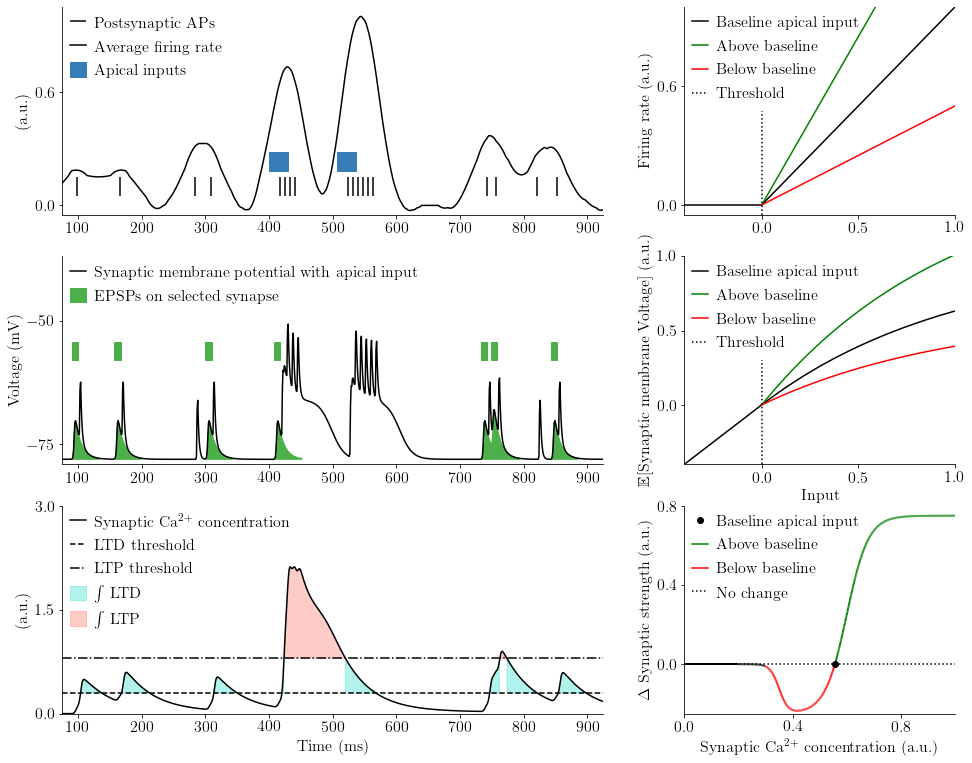

In [26]:
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 1, 1])
fig, axs = plt.subplots(3,2, figsize=(16,13), gridspec_kw=gs_kw)
fontsize = 16
b, e = 75, 925 
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

# Rate
spikes = homogeneous_poisson(0.015, 1000, 1)
singlespikes = spikes.copy()
add_bursts(spikes, 400, 600)
rates = moving_average(spikes, 61)
filtered = savgol_filter(rates, 91, 2)

ys = filtered / np.max(filtered)
xs = range(30, 970)
axs[0][0].vlines([i for i,j in enumerate(spikes) if j == 1], 0.05, 0.15, colors='black', label="Postsynaptic APs")
axs[0][0].plot(xs, ys, c='black', label='Average firing rate')
axs[0][0].add_patch(patches.Rectangle((400,0.18), 30, 0.1, color='#377eb8', label="Apical inputs"))
axs[0][0].add_patch(patches.Rectangle((507,0.18), 30, 0.1, color='#377eb8'))
axs[0][0].set_ylabel("(a.u.)", fontsize=fontsize)
axs[0][0].set_ylim((-0.05,1.05))
axs[0][0].set_xlim((75, 925))
axs[0][0].legend(fontsize=fontsize, loc='upper left')
axs[0][0].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[0][0].tick_params(axis='both', which='major', labelsize=fontsize)
axs[0][0].spines['right'].set_visible(False)
axs[0][0].spines['top'].set_visible(False)

xs = np.linspace(0,1,500)
axs[0][1].plot(np.linspace(-1,0,500), np.linspace(0,0,500), c='black')
p1, = axs[0][1].plot(xs, xs, c='black', label="Baseline apical input")
p2, = axs[0][1].plot(xs, xs*1.7, c='green', label="Above baseline")
p3, = axs[0][1].plot(xs, xs*0.5, c='red', label="Below baseline")
axs[0][1].axvline(0,0,0.5, linestyle='dotted', c='k', label='Threshold')
axs[0][1].set_ylabel("Firing rate (a.u.)", fontsize=fontsize)
axs[0][1].set_ylim((-0.05,1))
axs[0][1].set_xlim((-0.4,1))
axs[0][1].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[0][1].legend(fontsize=fontsize, loc='upper left')
axs[0][1].tick_params(axis='both', which='major', labelsize=fontsize)
axs[0][1].spines['right'].set_visible(False)
axs[0][1].spines['top'].set_visible(False)

# Voltage
time = 1000 # ms
resting = -78 # mV

epsp_delay = -5
epsp_fall = 10
epsp_rise = 150
epsp_spikes = divide_spikes(spikes, epsp_indices=[1,2,4,5,15,16,18])
glutamate_spikes = divide_spikes(spikes, epsp_indices=[1,2,4,5,6,7,8,15,16,18])

epsps = np.zeros(time)
for epsp_ in epsp_spikes:
    epsps += epsp(epsp_+epsp_delay, epsp_rise, epsp_fall, time) # * 2
epsps = epsps * 10

calcium1 = calcium_curve(423, time) * 12
calcium2 = calcium_curve(530, time) * 12
calcium = calcium1 + calcium2

bap_delay = 4 # ms
bap_rise = 400
bap_fall = 50

baps = np.zeros(time)
for bap in [i for i,j in enumerate(spikes) if j == 1]:
    baps += epsp(bap+bap_delay, bap_rise, bap_fall, time) # * 2
baps = baps * 20

baps_glutamate = np.zeros(time)
for bap in glutamate_spikes:
    baps_glutamate += epsp(bap+bap_delay, bap_rise, bap_fall, time) # * 2
baps_glutamate = baps_glutamate * 20

nofb_spikes = np.zeros(time)
for bap in [i for i,j in enumerate(singlespikes) if j == 1]:
    nofb_spikes += epsp(bap+bap_delay, bap_rise, bap_fall, time) # * 2 MODIFIED
nofb_spikes = nofb_spikes * 20

V_spine = calcium + baps + epsps + resting #*2
nofb_spikes = nofb_spikes + epsps + resting
nofb_spikes[:400] = np.nan
nofb_spikes[720:] = np.nan
plateau = saturate(calcium, 35) + resting
plateau[:400] = np.nan
plateau[730:] = np.nan


axs[1][0].plot(V_spine, c='black', label="Synaptic membrane potential with apical input")
# axs[1][0].plot(nofb_spikes, '--', color='black', label="Synaptic membrane potential without apical input")
axs[1][0].fill_between(np.linspace(0,time-1, time), epsps+resting, -78, where=(epsps+resting > -77.8), color='#4daf4a', interpolate=True)
for epsp_ in epsp_spikes:
    axs[1][0].add_patch(patches.Rectangle((epsp_+epsp_delay-4,-58), 10, 3.8, color='#4daf4a'))
axs[1][0].add_patch(patches.Rectangle((epsp_+epsp_delay,-85), 10, 2, color='#4daf4a', label="EPSPs on selected synapse"))
axs[1][0].set_ylabel("Voltage (mV)", fontsize=fontsize)
axs[1][0].set_ylim((-79, -37))
axs[1][0].set_xlim((75, 925))
axs[1][0].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[1][0].legend(fontsize=fontsize, loc='upper left')
axs[1][0].tick_params(axis='both', which='major', labelsize=fontsize)
axs[1][0].spines['right'].set_visible(False)
axs[1][0].spines['top'].set_visible(False)

elu = lambda x, a: -a*(np.exp(-x)-1)
xs = np.linspace(-1,0,500)
axs[1][1].plot(xs, xs, c='black', label="Baseline apical input")
xs = np.linspace(0,1,500)
p1, = axs[1][1].plot(xs, elu(xs, 1), c='black')
p2, = axs[1][1].plot(xs, elu(xs, 1.6), c='green', label="Above baseline")
p3, = axs[1][1].plot(xs, elu(xs, 0.625), c='red', label="Below baseline")
axs[1][1].axvline(0,0,0.5, linestyle='dotted', c='k', label='Threshold')
axs[1][1].set_ylabel("$\mathbb{E}[$Synaptic membrane Voltage$]$ (a.u.)", fontsize=fontsize)
axs[1][1].set_xlabel("Input", fontsize=fontsize)
axs[1][1].set_ylim((-0.4,1))
axs[1][1].set_xlim((-0.4,1))
axs[1][1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1][1].legend(fontsize=fontsize, loc="upper left")
axs[1][1].tick_params(axis='both', which='major', labelsize=fontsize)
axs[1][1].spines['right'].set_visible(False)
axs[1][1].spines['top'].set_visible(False)


# Calcium
V_spine = calcium1 + epsps + baps_glutamate + resting
vgcc_influx = lambda x: 1/(1+np.exp(-0.25*(x+49)))

Ca_max = 0.35
tau_c_decay = 50
tau_c_influx = 1
Ca_spine = np.zeros(time)
for t in range(time-1):
    Ca_spine[t+1] = Ca_spine[t] + 1/tau_c_decay *  - Ca_spine[t] + 1/tau_c_influx * (Ca_max-Ca_spine[t]/Ca_max) * vgcc_influx(V_spine[t])# * 1/(1+np.exp(4*(Ca_spine[t]/Ca_max-0.5)))
Ca_spine[0:93] = 0.2/20
Ca_spine = gaussian_filter1d(Ca_spine * 20, 2) - 0.2

LTD, dc = 0.3, 'turquoise'
LTP, pc = 0.8, 'salmon'
axs[2][0].plot(Ca_spine, c='black', label='Synaptic $\mathrm{Ca^{2+}}$ concentration')
axs[2][0].axhline(LTD,0,1000,linestyle='dashed', c='k', label="LTD threshold")
axs[2][0].axhline(LTP,0,1000,linestyle='dashdot', c='k', label="LTP threshold")
axs[2][0].fill_between(np.linspace(0,time-1, time), Ca_spine, LTD, where=np.logical_and(Ca_spine < LTP, Ca_spine > LTD), color=dc, alpha=0.4, interpolate=True, label="$\int$ LTD")
axs[2][0].fill_between(np.linspace(0,time-1, time), Ca_spine, LTP, where=(Ca_spine > LTP), color=pc, alpha=0.4, interpolate=True, label="$\int$ LTP")
axs[2][0].set_ylabel("(a.u.)", fontsize=fontsize)
axs[2][0].set_xlabel("Time (ms)", fontsize=fontsize)
axs[2][0].set_xlim((75, 925))
axs[2][0].set_ylim((0,3))
axs[2][0].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[2][0].legend(fontsize=fontsize, loc="upper left")
axs[2][0].tick_params(axis='both', which='major', labelsize=fontsize)
axs[2][0].spines['right'].set_visible(False)
axs[2][0].spines['top'].set_visible(False)

x = np.linspace(0,1,1000)
y = calcium_plasticity(x)

cmap = ListedColormap(['red', 'k', 'green'])
norm = BoundaryNorm([np.min(y), -0.01, 0.01, np.max(y)], cmap.N)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2)
lc.set_array(y)

axs[2][1].add_collection(lc)
axs[2][1].set_xlim(np.min(x), np.max(x))
axs[2][1].set_ylim(np.min(y)*1.1, np.max(y)*1.1)

axs[2][1].plot(0.556,0,'ko', label="Baseline apical input") 
axs[2][1].plot([], [], c='green', label="Above baseline")
axs[2][1].plot([], [], c='red', label="Below baseline")
axs[2][1].hlines(0,0,1,linestyles='dotted',colors='k', label="No change")
axs[2][1].set_xlim((0,1))
axs[2][1].set_ylim((-0.25,0.80))
axs[2][1].spines['right'].set_visible(False)
axs[2][1].spines['top'].set_visible(False)
axs[2][1].legend(fontsize=fontsize, loc="upper left")
axs[2][1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[2][1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[2][1].tick_params(axis='both', which='major', labelsize=fontsize)
axs[2][1].set_xlabel("Synaptic $\mathrm{Ca^{2+}}$ concentration (a.u.)", fontsize=fontsize)
axs[2][1].set_ylabel("$\Delta$ Synaptic strength (a.u.)", fontsize=fontsize)


plt.savefig(f'figs/multiplicative_feedback.png', dpi=360, bbox_inches="tight")
plt.savefig(f'figs/multiplicative_feedback.eps', format='eps', bbox_inches="tight")
plt.savefig(f'figs/multiplicative_feedback.svg', format='svg', bbox_inches="tight")